# Logistic Regression Model for Pitcher Injury Prediction

This notebook implements three variants of Logistic Regression to predict workload-related pitcher injuries.

## Model Variants:
1. **Variant 1: Backward Selection** - Stepwise feature selection to find optimal feature subset
2. **Variant 2: Interaction Terms** - Domain-driven interactions (e.g., velocity × volume) to model complex relationships
3. **Variant 3: With/Without Biomechanic Data** - Comparing models with and without biomechanic features (FB_velo, FB_spin, arm_angle, FB_vrel_var, FB_usage)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                            roc_auc_score, accuracy_score, log_loss)
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Data Loading and Preprocessing


In [2]:
# Load the data
pitch_injuries = pd.read_csv('pitcher_data_w_injuries.csv')

print(f"Original dataset shape: {pitch_injuries.shape}")
print(f"\nTarget variable distribution:")
print(pitch_injuries['is_workload_inj'].value_counts())
print(f"\nMissing values per column:")
print(pitch_injuries.isnull().sum()[pitch_injuries.isnull().sum() > 0])


Original dataset shape: (107325, 38)

Target variable distribution:
is_workload_inj
0    106810
1       515
Name: count, dtype: int64

Missing values per column:
FB_usage           24
FB_velo           712
FB_spin           931
arm_angle        2662
FB_vrel_var      2307
pos            106268
il_type        106268
injury         106268
dtype: int64


In [3]:
# Define feature columns
feature_cols = ['p_throws', 'pitches_last_appearence', 'season', 'days_since_last_appearence', 
                'num_appearence', 'FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 
                'FB_vrel_var', 'birth_country', 'age', 'bmi']

# Identify biomechanic features
biomechanic_features = ['FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var']
non_biomechanic_features = [f for f in feature_cols if f not in biomechanic_features]

print("Biomechanic features:", biomechanic_features)
print("Non-biomechanic features:", non_biomechanic_features)

# Select features and target
df = pitch_injuries[feature_cols + ['is_workload_inj']].copy()

# Remove rows with missing values
df_clean = df.dropna()
print(f"\nDataset shape after removing NAs: {df_clean.shape}")

# Handle birth_country as dummy variables (k-1 encoding)
print(f"\nEncoding 'birth_country' as dummy variables...")
print(f"  Unique countries: {df_clean['birth_country'].nunique()}")

country_dummies = pd.get_dummies(df_clean['birth_country'], prefix='country', drop_first=True, dtype=int)
print(f"  Created {len(country_dummies.columns)} dummy variables (k-1 encoding)")

# Combine features
df_clean = df_clean.drop('birth_country', axis=1)
df_clean = pd.concat([df_clean, country_dummies], axis=1)

# Separate features and target
X = df_clean.drop('is_workload_inj', axis=1)
y = df_clean['is_workload_inj'].astype(int)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Feature columns: {list(X.columns)}")


Biomechanic features: ['FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var']
Non-biomechanic features: ['p_throws', 'pitches_last_appearence', 'season', 'days_since_last_appearence', 'num_appearence', 'birth_country', 'age', 'bmi']

Dataset shape after removing NAs: (102976, 14)

Encoding 'birth_country' as dummy variables...
  Unique countries: 26
  Created 25 dummy variables (k-1 encoding)

Final feature matrix shape: (102976, 37)
Feature columns: ['p_throws', 'pitches_last_appearence', 'season', 'days_since_last_appearence', 'num_appearence', 'FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var', 'age', 'bmi', 'country_Brazil', 'country_Canada', 'country_China', 'country_Colombia', 'country_Cuba', 'country_Curacao', 'country_DOM', 'country_Dominican Republic', 'country_Germany', 'country_Italy', 'country_Japan', 'country_Lithuania', 'country_Mexico', 'country_Nicaragua', 'country_Panama', 'country_Peru', 'country_Portugal', 'country_Puerto Rico', 'country_Republic of 

In [4]:
# Balance the dataset as recommended by Professor Lai
# Generate a random sample of "no injury" with the same N as the number of injuries

injury_count = y.sum()
no_injury_indices = y[y == 0].index
injury_indices = y[y == 1].index

# Randomly sample non-injury cases to match injury count
np.random.seed(42)
no_injury_sample = np.random.choice(no_injury_indices, size=injury_count, replace=False)

# Combine balanced indices
balanced_indices = np.concatenate([injury_indices, no_injury_sample])
np.random.shuffle(balanced_indices)

X_balanced = X.loc[balanced_indices].reset_index(drop=True)
y_balanced = y.loc[balanced_indices].reset_index(drop=True)

print(f"Original class distribution:")
print(f"  Injuries: {y.sum()}")
print(f"  No injuries: {(y == 0).sum()}")
print(f"  Imbalance ratio: 1:{(y == 0).sum()/y.sum():.1f}")

print(f"\nBalanced class distribution:")
print(f"  Injuries: {y_balanced.sum()}")
print(f"  No injuries: {(y_balanced == 0).sum()}")
print(f"  Total samples: {len(y_balanced)}")
print(f"  Balance ratio: 1:1")


Original class distribution:
  Injuries: 499
  No injuries: 102477
  Imbalance ratio: 1:205.4

Balanced class distribution:
  Injuries: 499
  No injuries: 499
  Total samples: 998
  Balance ratio: 1:1


In [5]:
# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest class distribution:")
print(y_test.value_counts().sort_index())


Training set: 798 samples
Test set: 200 samples

Training class distribution:
is_workload_inj
0    399
1    399
Name: count, dtype: int64

Test class distribution:
is_workload_inj
0    100
1    100
Name: count, dtype: int64


In [7]:
# Variant 1: Backward selection using statsmodels
# First, check for and remove constant features and handle multicollinearity

print("Preparing data for backward selection...")

# Remove constant features
constant_features = [col for col in X_train.columns if X_train[col].nunique() <= 1]
if constant_features:
    print(f"Removing {len(constant_features)} constant features: {constant_features}")
    X_train_clean = X_train.drop(columns=constant_features)
    X_test_clean = X_test.drop(columns=constant_features)
else:
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()

# Check for perfect multicollinearity using rank
print(f"Original features: {X_train_clean.shape[1]}")
print(f"Matrix rank: {np.linalg.matrix_rank(X_train_clean.values)}")

# If rank is less than number of features, there's multicollinearity
# Use sklearn's LogisticRegression with L2 regularization first to identify important features
# Then use statsmodels for final model

print("\nUsing regularized logistic regression for initial feature selection...")
# Fit with L2 regularization to handle multicollinearity
lr_initial = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42, solver='lbfgs')
lr_initial.fit(X_train_clean, y_train)

# Get feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'feature': X_train_clean.columns,
    'coef_abs': np.abs(lr_initial.coef_[0])
}).sort_values('coef_abs', ascending=False)

print(f"\nTop 10 features by absolute coefficient:")
print(feature_importance.head(10))

# Start with all features and use backward selection with statsmodels
# But handle singular matrix errors gracefully
X_train_sm = sm.add_constant(X_train_clean)
X_test_sm = sm.add_constant(X_test_clean)

print("\nPerforming backward selection...")
print("Starting with all features...")

# Try to fit full model - if it fails due to singular matrix, use regularized approach
try:
    full_model = sm.Logit(y_train, X_train_sm).fit(disp=0, maxiter=500, method='lbfgs')
    print(f"\nFull model AIC: {full_model.aic:.2f}")
    print(f"Full model features: {X_train_sm.shape[1]}")
    use_statsmodels = True
except (np.linalg.LinAlgError, ValueError) as e:
    print(f"\nSingular matrix detected. Using regularized approach for feature selection.")
    print(f"Error: {str(e)}")
    use_statsmodels = False
    # Use sklearn's feature selection instead
    from sklearn.feature_selection import RFE
    lr_for_rfe = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
    # Select top 20 features using recursive feature elimination
    n_features_to_select = min(20, X_train_clean.shape[1])
    rfe = RFE(lr_for_rfe, n_features_to_select=n_features_to_select)
    rfe.fit(X_train_clean, y_train)
    selected_mask = rfe.support_
    selected_features = ['const'] + list(X_train_clean.columns[selected_mask])
    X_train_backward = X_train_sm[selected_features]
    X_test_backward = X_test_sm[selected_features]
    
    # Fit final model with selected features
    try:
        variant1_model = sm.Logit(y_train, X_train_backward).fit(disp=0, maxiter=500, method='lbfgs')
        print(f"\nRFE-selected model AIC: {variant1_model.aic:.2f}")
        print(f"Selected {len(selected_features)-1} features")
    except:
        # If still fails, just use sklearn model
        variant1_model = None
        print("Using sklearn model (statsmodels failed)")

if use_statsmodels:
    # Perform backward elimination based on AIC
    selected_features = list(X_train_sm.columns)
    current_model = full_model
    current_aic = full_model.aic

    print("\nBackward elimination process:")
    print("=" * 60)

    iteration = 0
    max_iterations = 50

    while iteration < max_iterations:
        iteration += 1
        pvalues = current_model.pvalues.drop('const')
        
        # Find feature with highest p-value (if > 0.05)
        non_sig = pvalues[pvalues > 0.05]
        
        if len(non_sig) == 0:
            print(f"\nNo more non-significant features (p > 0.05). Stopping.")
            break
        
        # Remove feature with highest p-value
        feature_to_remove = non_sig.idxmax()
        selected_features.remove(feature_to_remove)
        
        # Refit model
        X_train_selected = X_train_sm[selected_features]
        try:
            new_model = sm.Logit(y_train, X_train_selected).fit(disp=0, maxiter=500, method='lbfgs')
            new_aic = new_model.aic
            
            # Only keep if AIC improved or stayed similar (within 2)
            if new_aic <= current_aic + 2:
                current_model = new_model
                current_aic = new_aic
                print(f"Iteration {iteration}: Removed '{feature_to_remove}' | AIC: {current_aic:.2f} | Features: {len(selected_features)}")
            else:
                # AIC got worse, keep the feature
                selected_features.append(feature_to_remove)
                print(f"Iteration {iteration}: AIC increased, keeping '{feature_to_remove}' | Stopping.")
                break
        except (np.linalg.LinAlgError, ValueError):
            # If model fails due to singular matrix, keep the feature and try next
            selected_features.append(feature_to_remove)
            print(f"Iteration {iteration}: Singular matrix, keeping '{feature_to_remove}' | Trying next feature.")
            # Try removing a different feature
            if len(non_sig) > 1:
                continue
            else:
                break

    # Final backward-selected model
    X_train_backward = X_train_sm[selected_features]
    X_test_backward = X_test_sm[selected_features]

    try:
        variant1_model = sm.Logit(y_train, X_train_backward).fit(disp=0, maxiter=500, method='lbfgs')
        print("\n" + "=" * 60)
        print(f"Final backward-selected model:")
        print(f"  Features: {len(selected_features)} (removed {X_train_sm.shape[1] - len(selected_features)} features)")
        print(f"  AIC: {variant1_model.aic:.2f}")
        print(f"  Selected features: {[f for f in selected_features if f != 'const']}")
    except (np.linalg.LinAlgError, ValueError):
        print("\nWarning: Could not fit statsmodels model. Using sklearn model.")
        variant1_model = None

# Store for sklearn compatibility
variant1_sklearn = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
variant1_sklearn.fit(X_train_backward.drop('const', axis=1), y_train)

# If statsmodels model failed, use sklearn model for AIC/BIC calculation later
if variant1_model is None:
    print("\nNote: Using sklearn LogisticRegression for predictions.")
    print("AIC/BIC will be calculated using refitted statsmodels model if possible.")


Preparing data for backward selection...
Removing 12 constant features: ['country_Brazil', 'country_China', 'country_DOM', 'country_Germany', 'country_Italy', 'country_Lithuania', 'country_Peru', 'country_Portugal', 'country_South Africa', 'country_Taiwan', 'country_United Kingdom', 'country_VEN']
Original features: 25
Matrix rank: 25

Using regularized logistic regression for initial feature selection...

Top 10 features by absolute coefficient:
                       feature  coef_abs
24           country_Venezuela  0.757486
23                 country_USA  0.664919
0                     p_throws  0.403065
17               country_Japan  0.396515
18              country_Mexico  0.355689
21         country_Puerto Rico  0.305036
12              country_Canada  0.278010
13            country_Colombia  0.229646
16  country_Dominican Republic  0.208508
20              country_Panama  0.179619

Performing backward selection...
Starting with all features...

Full model AIC: 1158.26
Full mode

In [8]:
# Variant 2: Interaction terms
# Domain-driven interactions based on baseball knowledge:
# - Velocity × Volume (FB_velo × pitches_last_appearence): High velocity with high volume increases injury risk
# - Velocity × Rest (FB_velo × days_since_last_appearence): Velocity effect depends on rest
# - Volume × Rest (pitches_last_appearence × days_since_last_appearence): Volume effect depends on recovery time
# - Spin × Velocity (FB_spin × FB_velo): High spin with high velocity increases stress
# - Usage × Volume (FB_usage × pitches_last_appearence): Fastball usage with volume

print("Creating domain-driven interaction terms...")

# Start with base features
X_train_interactions = X_train.copy()
X_test_interactions = X_test.copy()

# Create interaction terms
interactions = {
    'FB_velo_x_pitches': X_train['FB_velo'] * X_train['pitches_last_appearence'],
    'FB_velo_x_rest': X_train['FB_velo'] * X_train['days_since_last_appearence'],
    'pitches_x_rest': X_train['pitches_last_appearence'] * X_train['days_since_last_appearence'],
    'FB_spin_x_velo': X_train['FB_spin'] * X_train['FB_velo'],
    'FB_usage_x_pitches': X_train['FB_usage'] * X_train['pitches_last_appearence'],
    'FB_velo_x_age': X_train['FB_velo'] * X_train['age'],
    'pitches_x_age': X_train['pitches_last_appearence'] * X_train['age']
}

# Add interactions to training data
for name, interaction in interactions.items():
    X_train_interactions[name] = interaction
    # Create same interaction for test data
    if 'FB_velo_x_pitches' in name:
        X_test_interactions[name] = X_test['FB_velo'] * X_test['pitches_last_appearence']
    elif 'FB_velo_x_rest' in name:
        X_test_interactions[name] = X_test['FB_velo'] * X_test['days_since_last_appearence']
    elif 'pitches_x_rest' in name:
        X_test_interactions[name] = X_test['pitches_last_appearence'] * X_test['days_since_last_appearence']
    elif 'FB_spin_x_velo' in name:
        X_test_interactions[name] = X_test['FB_spin'] * X_test['FB_velo']
    elif 'FB_usage_x_pitches' in name:
        X_test_interactions[name] = X_test['FB_usage'] * X_test['pitches_last_appearence']
    elif 'FB_velo_x_age' in name:
        X_test_interactions[name] = X_test['FB_velo'] * X_test['age']
    elif 'pitches_x_age' in name:
        X_test_interactions[name] = X_test['pitches_last_appearence'] * X_test['age']

print(f"Created {len(interactions)} interaction terms")
print(f"New feature count: {X_train_interactions.shape[1]} (added {len(interactions)} interactions)")
print(f"\nInteraction terms created:")
for name in interactions.keys():
    print(f"  - {name}")

# Fit model with interactions
variant2_model = LogisticRegression(max_iter=1000, random_state=42)
variant2_model.fit(X_train_interactions, y_train)

print(f"\nModel fitted with {X_train_interactions.shape[1]} features (including interactions)")


Creating domain-driven interaction terms...
Created 7 interaction terms
New feature count: 44 (added 7 interactions)

Interaction terms created:
  - FB_velo_x_pitches
  - FB_velo_x_rest
  - pitches_x_rest
  - FB_spin_x_velo
  - FB_usage_x_pitches
  - FB_velo_x_age
  - pitches_x_age

Model fitted with 44 features (including interactions)


## Model Variant 3: With/Without Biomechanic Data

Comparing models with and without biomechanic features to assess their contribution.


In [9]:
# Variant 3: With and without biomechanic data
# Identify columns related to biomechanic features (including country dummies)

# Get all column names that contain biomechanic feature names
biomechanic_cols = [col for col in X_train.columns if any(bf in col for bf in biomechanic_features)]
print(f"Biomechanic-related columns: {len(biomechanic_cols)}")
print(f"  {biomechanic_cols[:5]}...")

# Model 3a: WITH biomechanic data (full model)
X_train_with_bio = X_train.copy()
X_test_with_bio = X_test.copy()

variant3a_model = LogisticRegression(max_iter=1000, random_state=42)
variant3a_model.fit(X_train_with_bio, y_train)

print(f"\nVariant 3a (WITH biomechanic data):")
print(f"  Features: {X_train_with_bio.shape[1]}")
print(f"  Includes: FB_usage, FB_velo, FB_spin, arm_angle, FB_vrel_var")

# Model 3b: WITHOUT biomechanic data
X_train_without_bio = X_train.drop(columns=biomechanic_cols)
X_test_without_bio = X_test.drop(columns=biomechanic_cols)

variant3b_model = LogisticRegression(max_iter=1000, random_state=42)
variant3b_model.fit(X_train_without_bio, y_train)

print(f"\nVariant 3b (WITHOUT biomechanic data):")
print(f"  Features: {X_train_without_bio.shape[1]} (removed {len(biomechanic_cols)} biomechanic features)")
print(f"  Excludes: FB_usage, FB_velo, FB_spin, arm_angle, FB_vrel_var")


Biomechanic-related columns: 5
  ['FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var']...

Variant 3a (WITH biomechanic data):
  Features: 37
  Includes: FB_usage, FB_velo, FB_spin, arm_angle, FB_vrel_var

Variant 3b (WITHOUT biomechanic data):
  Features: 32 (removed 5 biomechanic features)
  Excludes: FB_usage, FB_velo, FB_spin, arm_angle, FB_vrel_var


## Cross-Validation for All Variants


In [10]:
# Perform cross-validation for all variants
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-Validation Results:")
print("=" * 60)

# Variant 1: Backward selection
cv_scores_v1 = cross_val_score(variant1_sklearn, X_train_backward.drop('const', axis=1), 
                               y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"Variant 1 (Backward Selection):")
print(f"  CV Accuracy: {cv_scores_v1.mean():.4f} (+/- {cv_scores_v1.std() * 2:.4f})")
print(f"  Features: {X_train_backward.shape[1] - 1}")  # -1 for const

# Variant 2: Interactions
cv_scores_v2 = cross_val_score(variant2_model, X_train_interactions, 
                               y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nVariant 2 (Interaction Terms):")
print(f"  CV Accuracy: {cv_scores_v2.mean():.4f} (+/- {cv_scores_v2.std() * 2:.4f})")
print(f"  Features: {X_train_interactions.shape[1]}")

# Variant 3a: With biomechanic
cv_scores_v3a = cross_val_score(variant3a_model, X_train_with_bio, 
                                y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nVariant 3a (WITH Biomechanic Data):")
print(f"  CV Accuracy: {cv_scores_v3a.mean():.4f} (+/- {cv_scores_v3a.std() * 2:.4f})")
print(f"  Features: {X_train_with_bio.shape[1]}")

# Variant 3b: Without biomechanic
cv_scores_v3b = cross_val_score(variant3b_model, X_train_without_bio, 
                                y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nVariant 3b (WITHOUT Biomechanic Data):")
print(f"  CV Accuracy: {cv_scores_v3b.mean():.4f} (+/- {cv_scores_v3b.std() * 2:.4f})")
print(f"  Features: {X_train_without_bio.shape[1]}")

print("=" * 60)


Cross-Validation Results:
Variant 1 (Backward Selection):
  CV Accuracy: 0.5952 (+/- 0.0547)
  Features: 6

Variant 2 (Interaction Terms):
  CV Accuracy: 0.5803 (+/- 0.0726)
  Features: 44

Variant 3a (WITH Biomechanic Data):
  CV Accuracy: 0.5940 (+/- 0.0529)
  Features: 37

Variant 3b (WITHOUT Biomechanic Data):
  CV Accuracy: 0.6015 (+/- 0.0706)
  Features: 32


## Figure 1: Training and Cross-Validation Error vs. Model Variants


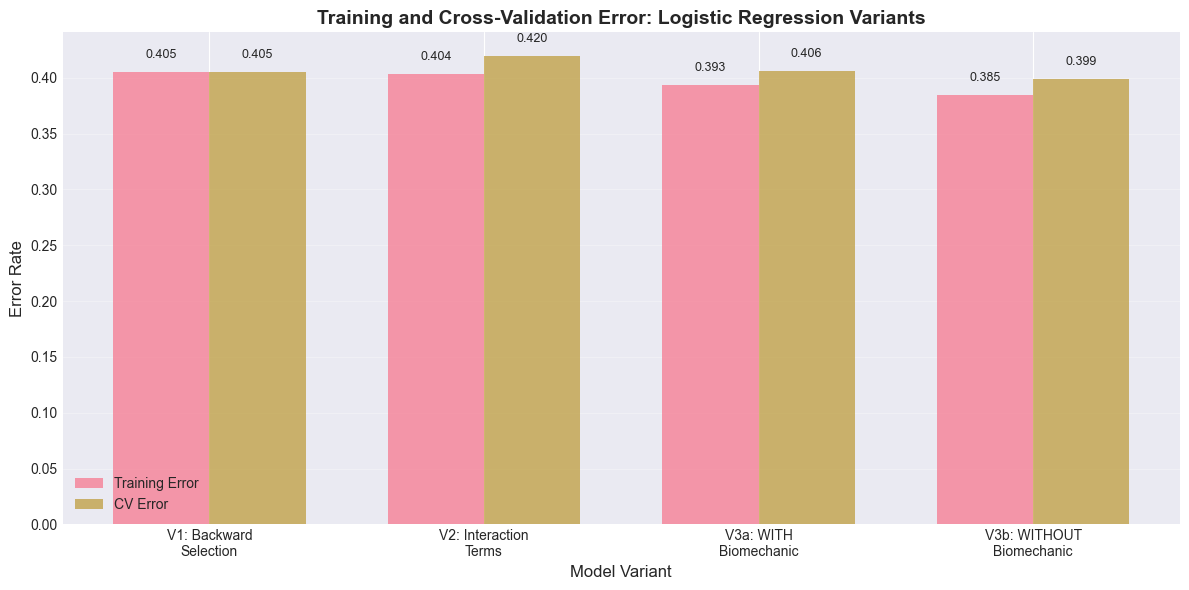

Figure 1: Training and Cross-Validation Error vs. Model Variants
This figure shows the trade-off between training and validation performance for each variant.


In [11]:
# Calculate training accuracies
train_pred_v1 = variant1_sklearn.predict(X_train_backward.drop('const', axis=1))
train_acc_v1 = accuracy_score(y_train, train_pred_v1)

train_pred_v2 = variant2_model.predict(X_train_interactions)
train_acc_v2 = accuracy_score(y_train, train_pred_v2)

train_pred_v3a = variant3a_model.predict(X_train_with_bio)
train_acc_v3a = accuracy_score(y_train, train_pred_v3a)

train_pred_v3b = variant3b_model.predict(X_train_without_bio)
train_acc_v3b = accuracy_score(y_train, train_pred_v3b)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

variants = ['V1: Backward\nSelection', 'V2: Interaction\nTerms', 
            'V3a: WITH\nBiomechanic', 'V3b: WITHOUT\nBiomechanic']
train_errors = [1 - train_acc_v1, 1 - train_acc_v2, 1 - train_acc_v3a, 1 - train_acc_v3b]
cv_errors = [1 - cv_scores_v1.mean(), 1 - cv_scores_v2.mean(), 
            1 - cv_scores_v3a.mean(), 1 - cv_scores_v3b.mean()]

x_pos = np.arange(len(variants))
width = 0.35

bars1 = ax.bar(x_pos - width/2, train_errors, width, label='Training Error', alpha=0.7)
bars2 = ax.bar(x_pos + width/2, cv_errors, width, label='CV Error', alpha=0.7)

ax.set_xlabel('Model Variant', fontsize=12)
ax.set_ylabel('Error Rate', fontsize=12)
ax.set_title('Training and Cross-Validation Error: Logistic Regression Variants', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(variants)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('lr_training_cv_error_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1: Training and Cross-Validation Error vs. Model Variants")
print("This figure shows the trade-off between training and validation performance for each variant.")


## Model Evaluation on Test Set


In [12]:
# Evaluate all models on test set
best_models = {
    'Variant 1 (Backward Selection)': (variant1_sklearn, X_test_backward.drop('const', axis=1)),
    'Variant 2 (Interaction Terms)': (variant2_model, X_test_interactions),
    'Variant 3a (WITH Biomechanic)': (variant3a_model, X_test_with_bio),
    'Variant 3b (WITHOUT Biomechanic)': (variant3b_model, X_test_without_bio)
}

test_results = {}

for name, (model, X_test_data) in best_models.items():
    # Predictions
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    
    # Metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_logloss = log_loss(y_test, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    test_results[name] = {
        'accuracy': test_acc,
        'auc': test_auc,
        'log_loss': test_logloss,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"\n{name}:")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test AUC-ROC: {test_auc:.4f}")
    print(f"  Test Log Loss: {test_logloss:.4f}")
    print(f"  Confusion Matrix:")
    print(f"    {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"    {cm[1,0]:4d}  {cm[1,1]:4d}")

# Naive baseline
naive_baseline = max(y_test.value_counts()) / len(y_test)
print(f"\nNaive Baseline Accuracy (always predict majority class): {naive_baseline:.4f}")



Variant 1 (Backward Selection):
  Test Accuracy: 0.5350
  Test AUC-ROC: 0.5674
  Test Log Loss: 0.6935
  Confusion Matrix:
      33    67
      26    74

Variant 2 (Interaction Terms):
  Test Accuracy: 0.6400
  Test AUC-ROC: 0.6594
  Test Log Loss: 0.6602
  Confusion Matrix:
      58    42
      30    70

Variant 3a (WITH Biomechanic):
  Test Accuracy: 0.5850
  Test AUC-ROC: 0.6362
  Test Log Loss: 0.6656
  Confusion Matrix:
      52    48
      35    65

Variant 3b (WITHOUT Biomechanic):
  Test Accuracy: 0.6150
  Test AUC-ROC: 0.6102
  Test Log Loss: 0.6817
  Confusion Matrix:
      53    47
      30    70

Naive Baseline Accuracy (always predict majority class): 0.5000


## Figure 2: Confusion Matrices for All Variants


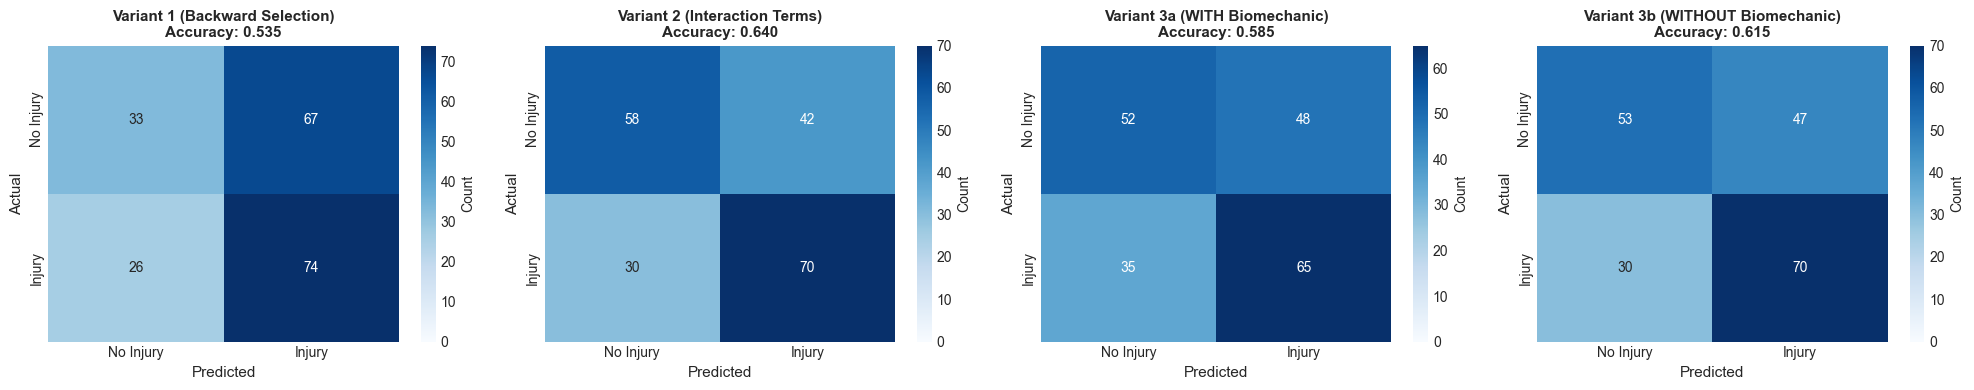

Figure 2: Confusion Matrices for All Variants
This figure shows the classification performance of each variant on the test set.


In [13]:
# Plot confusion matrices
n_models = len(test_results)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

if n_models == 1:
    axes = [axes]

for idx, (name, results) in enumerate(test_results.items()):
    cm = results['confusion_matrix']
    ax = axes[idx]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, vmin=0, vmax=cm.max())
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(f'{name}\nAccuracy: {results["accuracy"]:.3f}', fontsize=11, fontweight='bold')
    ax.set_xticklabels(['No Injury', 'Injury'])
    ax.set_yticklabels(['No Injury', 'Injury'])

plt.tight_layout()
plt.savefig('lr_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2: Confusion Matrices for All Variants")
print("This figure shows the classification performance of each variant on the test set.")


## Figure 3: ROC Curves for All Variants


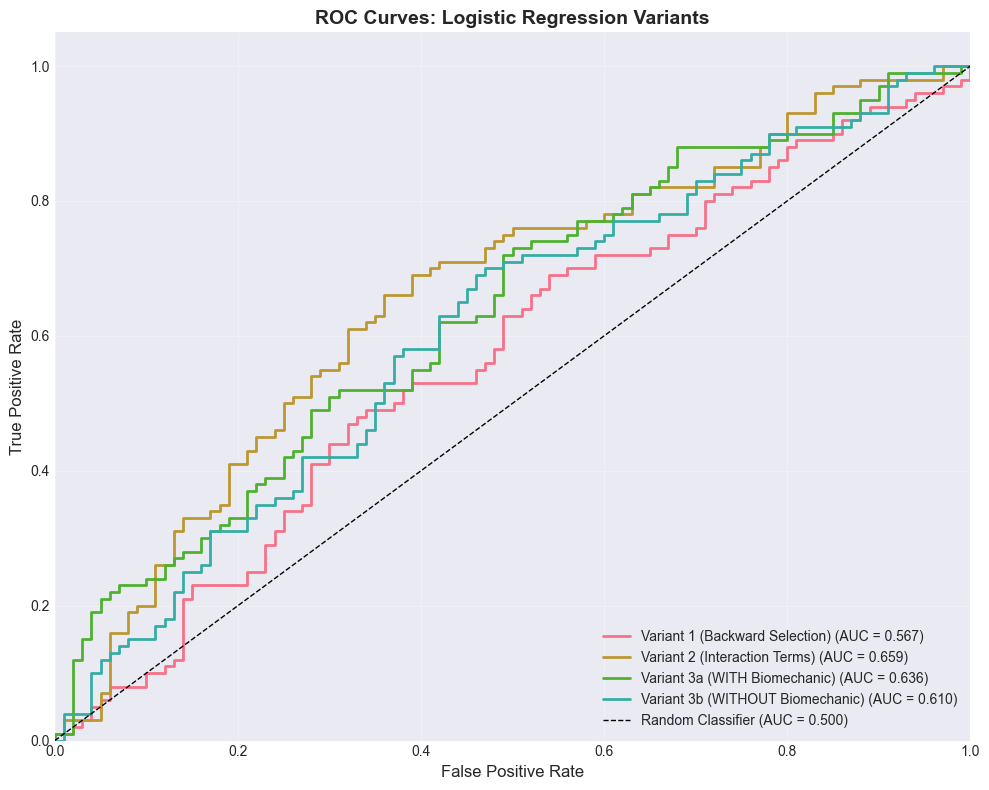

Figure 3: ROC Curves for All Variants
This figure shows the trade-off between true positive rate and false positive rate.


In [14]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, results in test_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {results["auc"]:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Logistic Regression Variants', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('lr_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3: ROC Curves for All Variants")
print("This figure shows the trade-off between true positive rate and false positive rate.")


## Figure 4: Model Accuracy Comparison (Including Naive Baseline)


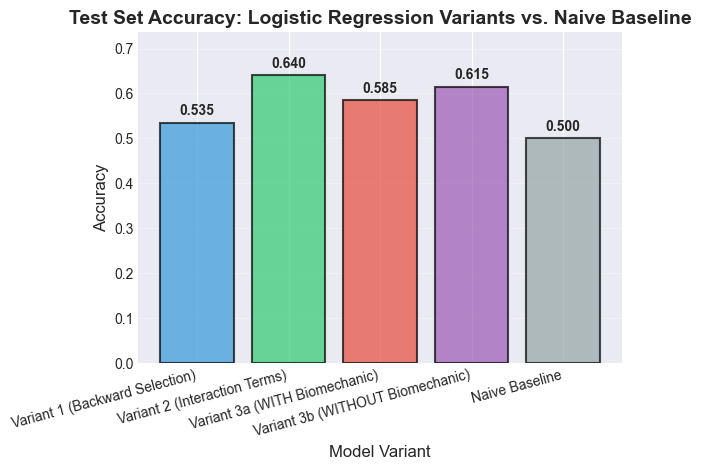

Figure 4: Model Accuracy Comparison
This figure compares the test accuracy of each variant against a naive baseline.


In [15]:
# Bar plot comparing accuracies
model_names = list(test_results.keys())
accuracies = [test_results[name]['accuracy'] for name in model_names]
accuracies.append(naive_baseline)
model_names.append('Naive Baseline')

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#95a5a6']
bars = plt.bar(range(len(model_names)), accuracies, color=colors[:len(model_names)], 
               alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Model Variant', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Test Set Accuracy: Logistic Regression Variants vs. Naive Baseline', 
         fontsize=14, fontweight='bold')
plt.xticks(range(len(model_names)), model_names, rotation=15, ha='right')
plt.ylim([0, max(accuracies) * 1.15])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('lr_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4: Model Accuracy Comparison")
print("This figure compares the test accuracy of each variant against a naive baseline.")


## Model Comparison Metrics: AIC and BIC

Comparing models using information criteria.


In [18]:
# Calculate AIC and BIC for all models
# For sklearn models, we need to calculate manually or refit with statsmodels

comparison_metrics = {}

# Variant 1: Try to get statsmodels model, otherwise refit
if variant1_model is not None:
    comparison_metrics['Variant 1 (Backward Selection)'] = {
        'AIC': variant1_model.aic,
        'BIC': variant1_model.bic,
        'Log-Likelihood': variant1_model.llf
    }
else:
    # Try to refit with statsmodels using selected features
    try:
        variant1_refit = sm.Logit(y_train, X_train_backward).fit(disp=0, maxiter=500, method='lbfgs')
        comparison_metrics['Variant 1 (Backward Selection)'] = {
            'AIC': variant1_refit.aic,
            'BIC': variant1_refit.bic,
            'Log-Likelihood': variant1_refit.llf
        }
    except:
        # If still fails, calculate approximate AIC/BIC from sklearn model
        # AIC = -2*log_likelihood + 2*k, BIC = -2*log_likelihood + k*log(n)
        y_pred_proba_v1 = variant1_sklearn.predict_proba(X_train_backward.drop('const', axis=1))[:, 1]
        log_likelihood = -log_loss(y_train, y_pred_proba_v1, normalize=False)
        k = X_train_backward.shape[1] - 1  # -1 for const
        n = len(y_train)
        aic_approx = -2 * log_likelihood + 2 * k
        bic_approx = -2 * log_likelihood + k * np.log(n)
        comparison_metrics['Variant 1 (Backward Selection)'] = {
            'AIC': aic_approx,
            'BIC': bic_approx,
            'Log-Likelihood': log_likelihood
        }
        print("Note: Using approximate AIC/BIC for Variant 1 (statsmodels unavailable)")

# For other variants, refit with statsmodels to get AIC/BIC
# Handle singular matrix errors for all variants

# Helper function to calculate AIC/BIC from sklearn model
def calculate_aic_bic_from_sklearn(model, X, y):
    """Calculate approximate AIC/BIC from sklearn logistic regression model"""
    y_pred_proba = model.predict_proba(X)[:, 1]
    log_likelihood = -log_loss(y, y_pred_proba, normalize=False)
    k = X.shape[1]
    n = len(y)
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + k * np.log(n)
    return aic, bic, log_likelihood

# Variant 2: Interactions
X_train_interactions_sm = sm.add_constant(X_train_interactions)
X_test_interactions_sm = sm.add_constant(X_test_interactions)
try:
    variant2_sm = sm.Logit(y_train, X_train_interactions_sm).fit(disp=0, maxiter=500, method='lbfgs')
    comparison_metrics['Variant 2 (Interaction Terms)'] = {
        'AIC': variant2_sm.aic,
        'BIC': variant2_sm.bic,
        'Log-Likelihood': variant2_sm.llf
    }
except (np.linalg.LinAlgError, ValueError):
    # Calculate approximate AIC/BIC from sklearn model
    aic, bic, ll = calculate_aic_bic_from_sklearn(variant2_model, X_train_interactions, y_train)
    comparison_metrics['Variant 2 (Interaction Terms)'] = {
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': ll
    }
    print("Note: Using approximate AIC/BIC for Variant 2 (statsmodels unavailable due to singular matrix)")

# Variant 3a: With biomechanic
X_train_with_bio_sm = sm.add_constant(X_train_with_bio)
try:
    variant3a_sm = sm.Logit(y_train, X_train_with_bio_sm).fit(disp=0, maxiter=500, method='lbfgs')
    comparison_metrics['Variant 3a (WITH Biomechanic)'] = {
        'AIC': variant3a_sm.aic,
        'BIC': variant3a_sm.bic,
        'Log-Likelihood': variant3a_sm.llf
    }
except (np.linalg.LinAlgError, ValueError):
    # Calculate approximate AIC/BIC from sklearn model
    aic, bic, ll = calculate_aic_bic_from_sklearn(variant3a_model, X_train_with_bio, y_train)
    comparison_metrics['Variant 3a (WITH Biomechanic)'] = {
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': ll
    }
    print("Note: Using approximate AIC/BIC for Variant 3a (statsmodels unavailable due to singular matrix)")

# Variant 3b: Without biomechanic
X_train_without_bio_sm = sm.add_constant(X_train_without_bio)
try:
    variant3b_sm = sm.Logit(y_train, X_train_without_bio_sm).fit(disp=0, maxiter=500, method='lbfgs')
    comparison_metrics['Variant 3b (WITHOUT Biomechanic)'] = {
        'AIC': variant3b_sm.aic,
        'BIC': variant3b_sm.bic,
        'Log-Likelihood': variant3b_sm.llf
    }
except (np.linalg.LinAlgError, ValueError):
    # Calculate approximate AIC/BIC from sklearn model
    aic, bic, ll = calculate_aic_bic_from_sklearn(variant3b_model, X_train_without_bio, y_train)
    comparison_metrics['Variant 3b (WITHOUT Biomechanic)'] = {
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': ll
    }
    print("Note: Using approximate AIC/BIC for Variant 3b (statsmodels unavailable due to singular matrix)")

print("Model Comparison Metrics (Lower is Better for AIC/BIC):")
print("=" * 80)
print(f"{'Model':<35s} {'AIC':>12s} {'BIC':>12s} {'Log-Likelihood':>15s}")
print("=" * 80)
for name, metrics in comparison_metrics.items():
    print(f"{name:<35s} {metrics['AIC']:>12.2f} {metrics['BIC']:>12.2f} {metrics['Log-Likelihood']:>15.2f}")

# Find best model by AIC and BIC
best_aic = min(comparison_metrics.items(), key=lambda x: x[1]['AIC'])
best_bic = min(comparison_metrics.items(), key=lambda x: x[1]['BIC'])

print("\n" + "=" * 80)
print(f"Best Model by AIC: {best_aic[0]} (AIC = {best_aic[1]['AIC']:.2f})")
print(f"Best Model by BIC: {best_bic[0]} (BIC = {best_bic[1]['BIC']:.2f})")
print("\nNote: AIC and BIC penalize model complexity. Lower values indicate better")
print("model fit while accounting for the number of parameters.")


Model Comparison Metrics (Lower is Better for AIC/BIC):
Model                                        AIC          BIC  Log-Likelihood
Variant 1 (Backward Selection)           1072.33      1105.10         -529.17
Variant 2 (Interaction Terms)            1172.26      1326.77         -553.13
Variant 3a (WITH Biomechanic)            1158.26      1280.00         -553.13
Variant 3b (WITHOUT Biomechanic)         1089.28      1187.60         -523.64

Best Model by AIC: Variant 1 (Backward Selection) (AIC = 1072.33)
Best Model by BIC: Variant 1 (Backward Selection) (BIC = 1105.10)

Note: AIC and BIC penalize model complexity. Lower values indicate better
model fit while accounting for the number of parameters.


## Figure 5: Coefficient Comparison (Variant 3: With vs Without Biomechanic)

Comparing coefficients to see the contribution of biomechanic features.


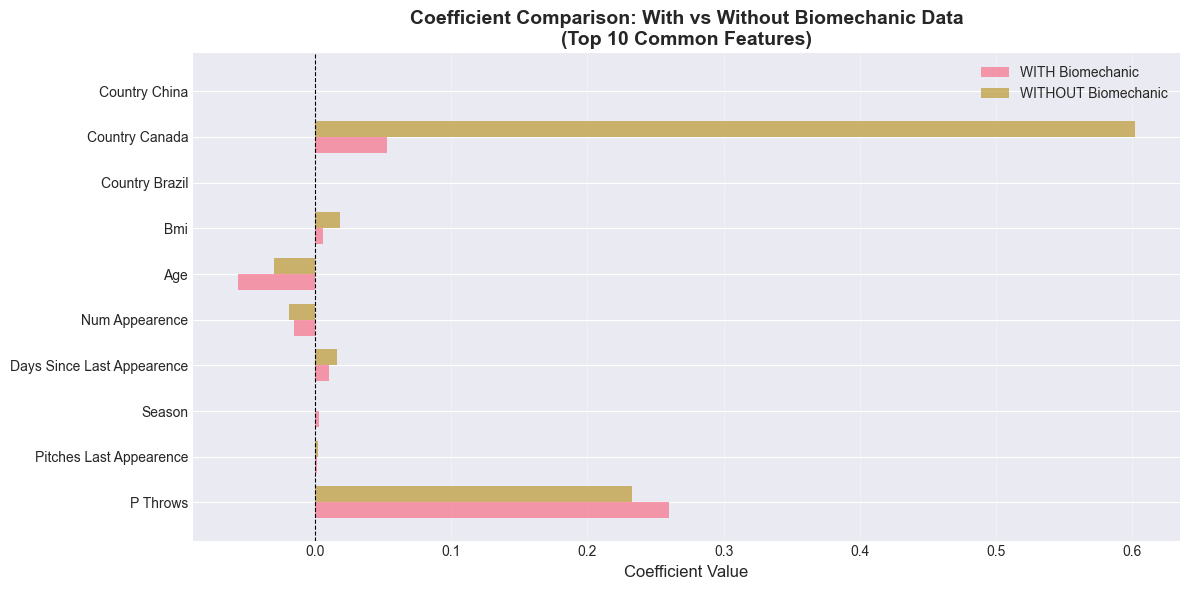

Figure 5: Coefficient Comparison
This figure compares coefficients between models with and without biomechanic data.
Shows how the inclusion of biomechanic features affects the estimated relationships.


In [17]:
# Compare coefficients between models with and without biomechanic data
# Get common features (non-biomechanic)
common_features = [f for f in X_train_without_bio.columns if f in X_train_with_bio.columns]

# Get coefficients
coef_with = variant3a_model.coef_[0]
coef_without = variant3b_model.coef_[0]

# Match coefficients for common features
coef_with_common = []
coef_without_common = []
feature_names_common = []

for feat in common_features[:10]:  # Limit to top 10 for readability
    if feat in X_train_with_bio.columns and feat in X_train_without_bio.columns:
        idx_with = list(X_train_with_bio.columns).index(feat)
        idx_without = list(X_train_without_bio.columns).index(feat)
        coef_with_common.append(coef_with[idx_with])
        coef_without_common.append(coef_without[idx_without])
        feature_names_common.append(feat.replace('_', ' ').title())

# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(feature_names_common))
width = 0.35

bars1 = ax.barh(x_pos - width/2, coef_with_common, width, label='WITH Biomechanic', alpha=0.7)
bars2 = ax.barh(x_pos + width/2, coef_without_common, width, label='WITHOUT Biomechanic', alpha=0.7)

ax.set_yticks(x_pos)
ax.set_yticklabels(feature_names_common)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Coefficient Comparison: With vs Without Biomechanic Data\n(Top 10 Common Features)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('lr_coefficient_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5: Coefficient Comparison")
print("This figure compares coefficients between models with and without biomechanic data.")
print("Shows how the inclusion of biomechanic features affects the estimated relationships.")
